In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os
import re
import numpy as np
import pickle
import scipy.io as so
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.autograd import Variable
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import sys
sys.path.append('/content/drive/MyDrive/WeberLab/')
import random

Mounted at /content/drive


In [ ]:
torch.manual_seed(42) # For consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.8.0+cu126
cuda:0


In [ ]:
# Modified specifically to look at the 3_remdix sleep state file

# Modified specifically to look at the 3_remix sleep state file
def load_stateidx(ppath, name, ann_name=''):
    """ load the sleep state file of recording (folder) $ppath/$name
    @Return:
        M,K         sequence of sleep states, sequence of
                    0'1 and 1's indicating non- and annotated states
    """
    ddir = os.path.join(ppath, name)
    ppath, name = os.path.split(ddir)

    if ann_name == '':
        ann_name = name

    remidxfile3 = os.path.join(ppath, name, '3_remidx_' + ann_name + '.txt')
    remidxfile_regular = os.path.join(ppath, name, 'remidx_' + ann_name + '.txt')

    # Check if '3_remidx_' file exists, if not use 'remidx_' file
    if os.path.exists(remidxfile3):
      remidxfile = remidxfile3
      print('3_remdix')

    else:
      remidxfile = remidxfile_regular
      print('remdix')


    f = open(remidxfile, 'r')
    lines = f.readlines()
    f.close()

    n = 0
    for l in lines:
        if re.match('\d', l):
            n += 1

    M = np.zeros(n, dtype='int')
    K = np.zeros(n, dtype='int')

    i = 0
    for l in lines :

        if re.search('^\s+$', l) :
            continue
        if re.search('\s*#', l) :
            continue

        if re.match('\d+\s+-?\d+', l) :
            a = re.split('\s+', l)
            M[i] = int(a[0])
            K[i] = int(a[1])
            i += 1

    return M,K






# Data loader for stage 1
class CustomDataset(Dataset):
  def __init__(self, data, labels, window_size):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.uint8)
    self.window_size = window_size

  def __len__(self):
    return len(self.data) // self.window_size

  def __getitem__(self, index):
    x = self.data[index*window_size:index*window_size+window_size][:]
    label_index = min(index * self.window_size, len(self.labels) - 1)
    y = self.labels[label_index]
    y = y.long()

    # Perform one-hot encoding on y
    y = y - 1 # shift the labels to start at 0
    y_encoded = F.one_hot(y, num_classes = 3)

    x = x.view(-1, 2)
    return x, y_encoded


# Data loader for stage 2
class CustomDatasetFC(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x, y

# Create segments for training
def create_segments(array, segment_length, overlap):
    segments = []
    stride = segment_length - overlap
    for i in range(0, len(array) - segment_length + 1, stride):
        segments.append(array[i:i+segment_length])
    return segments

segment_length = 51
overlap = 50

# # Create overlapping segments
# segments = create_segments(predicted_labels,
#                            segment_length, overlap)

# segments




def load_features(name, file_type, custom_length=False):
  output = so.loadmat(os.path.join(ppath, name, '{}.mat'.format(file_type)), squeeze_me=True)[file_type]
  output = output[:(len(output) // factor) * factor]

  if custom_length:
    output = output[start_index*ndown: start_index*ndown + sample_len]
    output = output[: sample_len]

  output = sleepy.downsample_vec(output, ndown)
  output = output.astype('float16')
  return output

def load_labels(name, custom_length=False):
  m = load_stateidx(ppath, name)[0]
  m = m.astype('i')
  m = m[:-1]
  if custom_length:
    m = m[:int(sample_len / factor)]

  for i in range(len(m)):
    if m[i] > 3:
      m[i] = 3
  return m

def train_test_split(data):
  x_indices = list(range(len(data)))
  x_split = int(np.floor(validation_split * len(data)))

  x_train_indices, x_val_indices = x_indices[x_split:], x_indices[:x_split]

  x_train = data[x_train_indices]
  x_test = data[x_val_indices]

  return x_train, x_test

def my_bpfilter(x, w0, w1, N=4,bf=True):
    """
    create N-th order bandpass Butterworth filter with corner frequencies
    w0*sampling_rate/2 and w1*sampling_rate/2
    """
    #from scipy import signal
    #taps = signal.firwin(numtaps, w0, pass_zero=False)
    #y = signal.lfilter(taps, 1.0, x)
    #return y
    from scipy import signal
    b,a = signal.butter(N, [w0, w1], 'bandpass')
    if bf:
        y = signal.filtfilt(b,a, x)
    else:
        y = signal.lfilter(b,a, x)

    return y

def get_sr(ppath, name):
    """
    read and return sampling rate (SR) from the info.txt file $ppath/$name/info.txt
    """
    fid = open(os.path.join(ppath, name, 'info.txt'), newline=None)
    lines = fid.readlines()
    fid.close()
    values = []
    for l in lines :
        a = re.search("^" + 'SR' + ":" + "\s+(.*)", l)
        if a :
            values.append(a.group(1))
    return float(values[0])

<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\d'
<>:50: SyntaxWarning: invalid escape sequence '\s'
<>:183: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\d'
<>:50: SyntaxWarning: invalid escape sequence '\s'
<>:183: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1735632743.py:35: SyntaxWarning: invalid escape sequence '\d'
  if re.match('\d', l):
/tmp/ipython-input-1735632743.py:44: SyntaxWarning: invalid escape sequence '\s'
  if re.search('^\s+$', l) :
/tmp/ipython-input-1735632743.py:46: SyntaxWarning: invalid escape sequence '\s'
  if re.search('\s*#', l) :
/tmp/ipython-input-1735632743.py:49: SyntaxWarning: invalid es

In [ ]:
from torch import sparse
# Bidirectional LSTM
class biLSTM(nn.Module):
  def __init__(self, input_size, window_len, hidden_size=128, num_layers=2, dropout=0.2):
    super(biLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
    self.fc = nn.Sequential(
          nn.BatchNorm1d(hidden_size*2),
          nn.Linear(hidden_size*2, hidden_size),
          nn.ReLU(),
          nn.BatchNorm1d(hidden_size),
          nn.Linear(hidden_size, 64),
          nn.ReLU(),
          nn.Linear(64, 3), # three brain states: 1, 2, 3 (--> now 0, 1, 2 due to shift)
    )

    self.softmax = nn.Softmax(dim=1)
    self.dropout = nn.Dropout(dropout)


  def forward(self, x):
    batch_size, seq_len, num_channels = x.size()

    h0 = torch.randn(2 * self.num_layers, batch_size, self.hidden_size).double().to(device)
    c0 = torch.randn(2 * self.num_layers, batch_size, self.hidden_size).double().to(device)

    x = x.permute(0, 1, 2)  # Transpose the tensor to match the shape (batch, seq_len, num_channels)

    outl, _ = self.lstm(x, (h0, c0))
    out = outl[:, -1, :]

    out = self.fc(out)
    return out


class FCNet(nn.Module):
    def __init__(self, dropout=0.2):
        super(FCNet, self).__init__()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(segment_length * 3, 64), # ADD TO SEG LEGTH IF WE ARE LOOKING AT SPEC
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 3),
        )

        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        # out = self.fc(x)
        out = self.fc(x) + x[:,int((segment_length-1)/2+0.1)]   ## (segment_length-1)/2
        return out

In [ ]:
def time_morph(X, nstates):
    """
    upsample vector or matrix X to nstates states
    :param X, vector or matrix; if matrix, the rows are upsampled.
    :param nstates, number of elements or rows of returned vector or matrix
    I want to upsample m by a factor of x such that
    x*m % nstates == 0,
    a simple soluation is to set x = nstates
    then nstates * m / nstates = m.
    so upsampling X by a factor of nstates and then downsampling by a factor
    of m is a simple solution...
    """
    m = X.shape[0]
    A = upsample_mx(X, nstates)
    # now we have m * nstates rows
    if X.ndim == 1:
        Y = downsample_vec(A, int((m * nstates) / nstates))
    else:
        Y = downsample_mx(A, int((m * nstates) / nstates))
    # now we have m rows as requested
    return Y

def upsample_mx(x, nbin):
    """
    if x is a vector:
        upsample the given vector $x by duplicating each element $nbin times
    if x is a 2d array:
        upsample each matrix by duplication each row $nbin times
    """
    if nbin == 1:
        return x

    nelem = x.shape[0]
    if x.ndim == 1:
        y = np.zeros((nelem * nbin,))
        for k in range(nbin):
            y[k::nbin] = x
    else:
        y = np.zeros((nelem * nbin, x.shape[1]))
        for k in range(nbin):
            y[k::nbin, :] = x

    return y

def downsample_mx(X, nbin):
    """
    y = downsample_vec(x, nbin)
    downsample the vector x by replacing nbin consecutive
    bin by their mean
    @RETURN: the downsampled vector
    """
    n_down = int(np.floor(X.shape[0] / nbin))
    X = X[0:n_down * nbin, :]
    X_down = np.zeros((n_down, X.shape[1]))

    # 0 1 2 | 3 4 5 | 6 7 8
    for i in range(nbin):
        idx = list(range(i, int(n_down * nbin), int(nbin)))
        X_down += X[idx, :]

    return X_down / nbin

def downsample_vec(x, nbin):
    """
    y = downsample_vec(x, nbin)
    downsample the vector x by replacing nbin consecutive \
    bin by their mean \
    @RETURN: the downsampled vector
    """
    n_down = int(np.floor(len(x) / nbin))
    x = x[0:n_down*nbin]
    x_down = np.zeros((n_down,))

    # 0 1 2 | 3 4 5 | 6 7 8
    for i in range(nbin) :
        idx = list(range(i, int(n_down*nbin), int(nbin)))
        x_down += x[idx]

    return x_down / nbin

In [ ]:
import io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=device)
        else: return super().find_class(module, name)

biLSTM_model = CPU_Unpickler(open('/content/drive/MyDrive/MultiVanillaModelPart1N.pkl',"rb")).load()
fc_model = CPU_Unpickler(open('/content/drive/MyDrive/MultiVanillaModelPart2Ov2.pkl',"rb")).load()

In [ ]:
fc_model

FCNet(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=153, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [ ]:
biLSTM_model

biLSTM(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc): Sequential(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.1, inplace=False)
)

remdix


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(
/tmp/ipython-input-1079138801.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_classes = torch.tensor(predicted_classes)
/tmp/ipython-input-1735632743.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.int64)


Test Subject: JW34_072925n2 | biLSTM Accuracy: 79.1040888966056 | FC Accuracy: 88.96154852210306
remdix


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(
/tmp/ipython-input-1079138801.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_classes = torch.tensor(predicted_classes)
/tmp/ipython-input-1735632743.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.int64)


Test Subject: JW32_080225n2 | biLSTM Accuracy: 87.15166247070059 | FC Accuracy: 97.06164443281891
remdix


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(
/tmp/ipython-input-1079138801.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_classes = torch.tensor(predicted_classes)
/tmp/ipython-input-1735632743.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.int64)


Test Subject: JW34_080225n2 | biLSTM Accuracy: 80.30210955812136 | FC Accuracy: 89.91193652454443
remdix


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(
/tmp/ipython-input-1079138801.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_classes = torch.tensor(predicted_classes)
/tmp/ipython-input-1735632743.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.int64)


Test Subject: JW31_080225n2 | biLSTM Accuracy: 85.51089504297248 | FC Accuracy: 96.05894149446334
remdix


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(
/tmp/ipython-input-1079138801.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_classes = torch.tensor(predicted_classes)
/tmp/ipython-input-1735632743.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.int64)


Test Subject: JW32_072925n2 | biLSTM Accuracy: 87.4902335272159 | FC Accuracy: 96.68672072543377
remdix


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(
/tmp/ipython-input-1079138801.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_classes = torch.tensor(predicted_classes)
/tmp/ipython-input-1735632743.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.int64)


Test Subject: JW16_050525n2 | biLSTM Accuracy: 88.2368261133779 | FC Accuracy: 93.05083267939663
remdix


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:1124: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1479.)
  result = _VF.lstm(
/tmp/ipython-input-1079138801.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_classes = torch.tensor(predicted_classes)
/tmp/ipython-input-1735632743.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.int64)


Test Subject: JW31_072925n2 | biLSTM Accuracy: 85.63243337095234 | FC Accuracy: 94.36742523323743


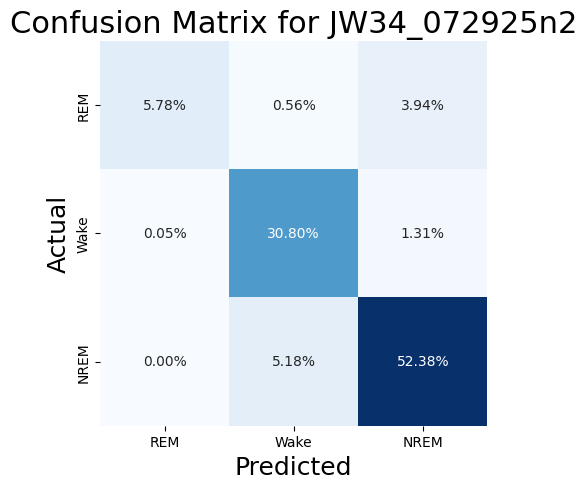

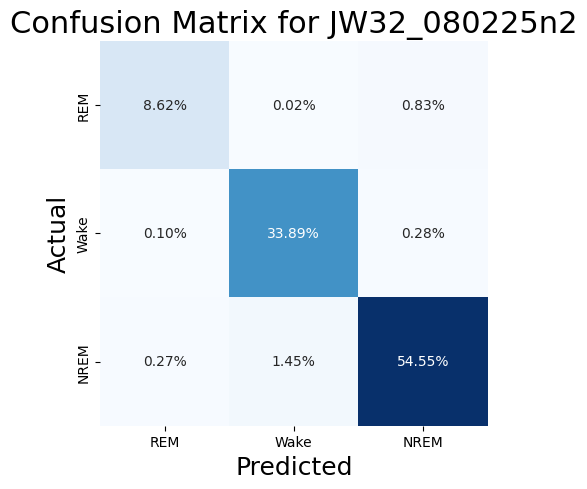

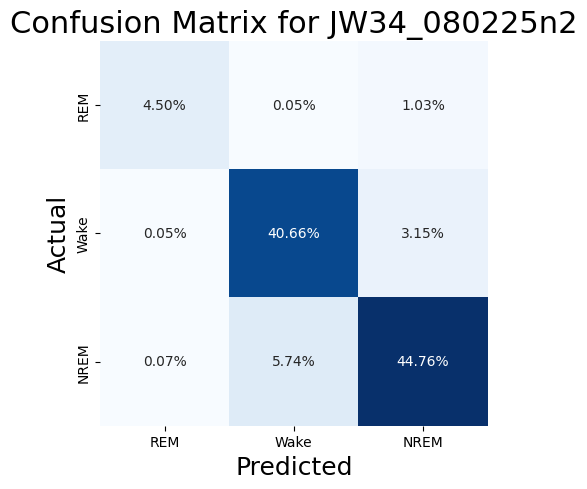

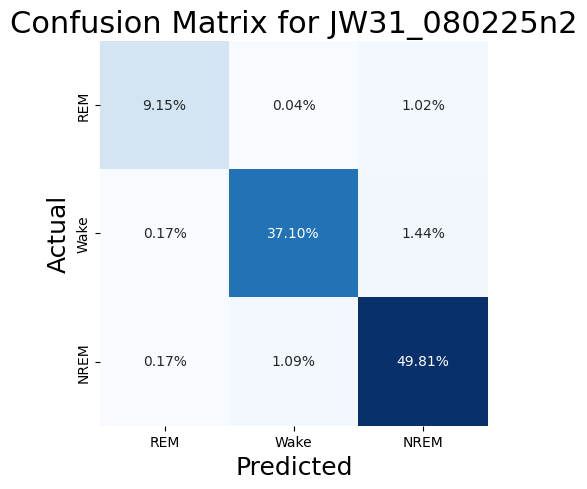

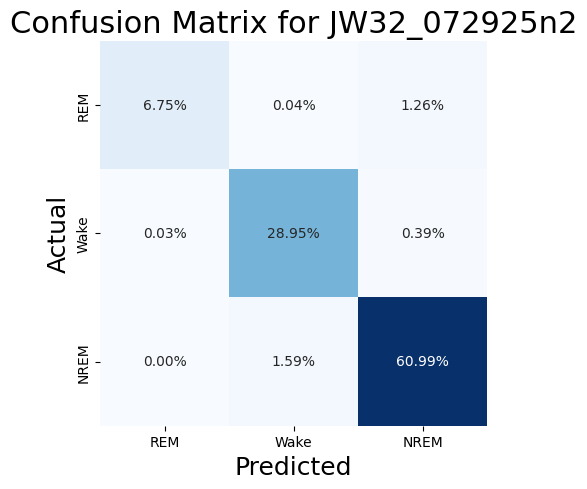

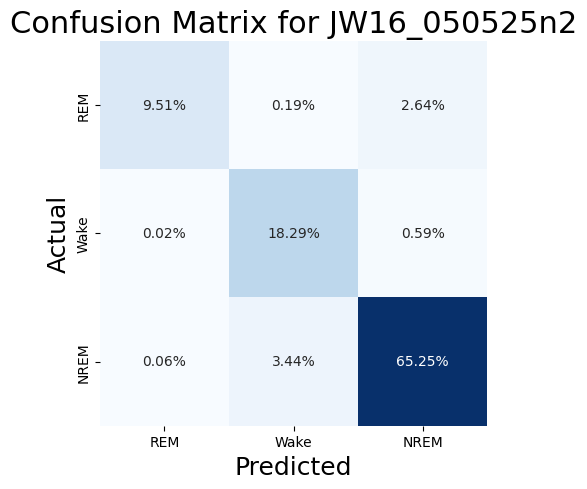

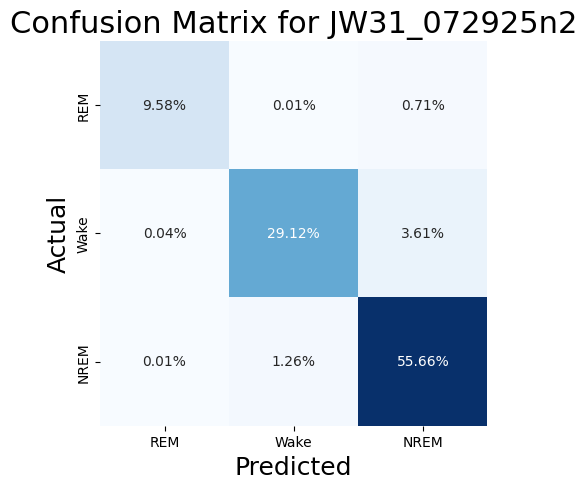

In [ ]:
# Concatenate the EEG, EMG, and sleep state (M) of the list of recordings
ppath = '/content/drive/MyDrive/SleepClass/heart_rate_new'
recordings = os.listdir(ppath)

recordings = ['JW34_072925n2', 'JW32_080225n2', 'JW34_080225n2', 'JW31_080225n2',
              'JW32_072925n2', 'JW16_050525n2', 'JW31_072925n2']
ndown = 4
factor = 2500
for name in recordings:
  m = load_stateidx(ppath, name)[0]
  m = m.astype('i')
  m = m[:-1] # cut off the end that doesn't match
  len_m = len(m)

  eeg = so.loadmat(os.path.join(ppath, name, 'EEG.mat'), squeeze_me=True)['EEG']
  eeg = eeg[:(len_m) * factor]    # truncate eeg length to the number of windows
  eeg = downsample_vec(eeg, ndown)
  eeg = eeg.astype('float16')

  emg = so.loadmat(os.path.join(ppath, name, 'EMG.mat'), squeeze_me=True)['EMG']
  emg = emg[:(len_m) * factor]
  emg = downsample_vec(emg, ndown)
  emg = emg.astype('float16')

  # Change all the sleep states above 3 to NREM -- can change to separate out microarousals
  for i in range(len(m)):
    if m[i] > 3:
      m[i] = 3
    if m[i] == 0: # changed the unannotated segments to NREM
      m[i] = 3
      print("There are weird annotations in here.")

  # Prepare the data for testing
  m_upsampled = np.repeat(m, int(factor/ndown))
  x_input = np.vstack((eeg, emg)).T
  input = StandardScaler().fit_transform(x_input)

  ### STAGE 1
  window_size = 625
  input_size = 2
  train_dataset = CustomDataset(input, m_upsampled, window_size=window_size)
  batch_size = 128
  loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

  random.seed(42)
  biLSTM_model.eval()
  test_predicted_labels = []
  test_real_labels = []
  val_correct = 0
  val_total = 0
  with torch.no_grad():
    for iter, (input, target) in enumerate(loader):
          input = input.to(device).double()
          target = target.to(device).double()

          output = biLSTM_model(input)

          test_predicted_labels.extend(output.tolist())
          test_real_labels.extend(target.tolist())

  test_predicted_labels = torch.tensor(test_predicted_labels)
  test_real_labels = torch.tensor(test_real_labels)

  val_output = F.one_hot(torch.max(test_predicted_labels, dim=1, keepdim=True)[1], num_classes = 3).squeeze()
  if val_output.dim() == 1:
    predicted_classes = torch.argmax(val_output, dim=0)
  else:
    predicted_classes = torch.argmax(val_output, dim=1)

  predicted_classes = torch.tensor(predicted_classes)
  val_correct = (predicted_classes == torch.argmax(test_real_labels, dim=1)).sum().item()
  val_total = test_real_labels.size(0)

  val_accuracy = 100 * val_correct / val_total

  # Stage 2
  idx = int(overlap/2)
  final_segments = np.array(create_segments(test_predicted_labels,
                           segment_length, overlap))
  final_labels = test_real_labels[idx:len(test_real_labels) - idx]

  # final_segments = StandardScaler().fit_transform(final_segments.reshape(len(final_segments),-1)).reshape(-1, segment_length, 3)

  # def minmax_scale(x, axis=None):
  #   min = np.min(x, axis=axis, keepdims=True)
  #   max = np.max(x, axis=axis, keepdims=True)
  #   result = (x-min)/(max-min)
  #   return result

  # def zscore_scale(x, axis=None):
  #   mean = np.mean(x, axis=axis, keepdims=True)
  #   std = np.std(x, axis=axis, keepdims=True)
  #   std = np.where(std == 0, 1, std)
  #   result = (x-mean)/std
  #   return result

  # final_segments = zscore_scale(final_segments, axis=2)
  axis = (0, 2)   ## this is to ensure the same timepoint is divided by the same mean, while this mean is representing the whole trainig set
  mean_x = np.nanmean(final_segments, axis=axis, keepdims=True)
  std_x = np.nanstd(final_segments, axis=axis, keepdims=True)
  final_segments = ((final_segments - mean_x) / std_x).astype('<f8')

  # Fully connected layer data loader
  test_dataset = CustomDatasetFC(final_segments, final_labels)

  # Create data loaders
  batch_size = 128
  test_loader_fc = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  fc_model.eval()
  final_test_predicted_labels = []
  final_test_real_labels = []
  val_correct = 0
  val_total = 0
  with torch.no_grad():
      for iter, (input, target) in enumerate(test_loader_fc):
          input = input.to(device).double()
          target = target.to(device).double()

          val_output = fc_model(input)

          val_output_classes = torch.argmax(val_output, dim=1) + 1
          final_test_predicted_labels.extend(val_output_classes.tolist())
          target_classes = torch.argmax(target, dim=1) + 1
          final_test_real_labels.extend(target_classes.tolist())


          val_output = F.one_hot(torch.max(val_output, dim=1, keepdim=True)[1], num_classes = 3).squeeze()
          val_correct += (torch.argmax(val_output, dim=1) == torch.argmax(target, dim=1)).sum().item()
  final_test_real_labels = torch.tensor(final_test_real_labels)
  val_total = final_test_real_labels.size(0)

  fc_val_accuracy = 100 * val_correct / val_total


  print("Test Subject: {} | biLSTM Accuracy: {} | FC Accuracy: {}"
          .format(name, val_accuracy, fc_val_accuracy))

  y_true = final_test_real_labels
  y_pred = final_test_predicted_labels

  cf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 2, 3])
  xticks = ['REM', 'Wake', 'NREM']
  yticks = ['REM', 'Wake', 'NREM']

  fig, ax = plt.subplots(figsize=(5, 5))
  fig = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues', cbar=False, xticklabels=xticks, yticklabels=yticks)

  ax.set_xlabel('Predicted', fontsize=18)
  ax.set_ylabel('Actual', fontsize=18)
  plt.title('Confusion Matrix for ' + name, fontsize=22)



In [ ]:
predicted_classes

tensor([2, 2, 2,  ..., 2, 2, 2])

In [ ]:
def plot_hypnograms(ppath, recordings, tbin=0, unit='h', ma_thr=20, title='', tstart=0, tend=-1):
    """
    plot all hypnograms specified in @recordings
    :param ppath: base folder
    :param recordings: list of recordings
    :param tbin: tbin for xticks
    :param unit: time unit; h - hour, min - minute, s - second
    :param ma_thr: float, wake periods shorter than $ma_thr are considered as microarousals and further converted to NREM
    :param tstart: float, start time point (in seconds!) of hypnograms
    :param tend: float, last shown time point (in seconds!)
    :param title: optional title for figure
    """
    recordings = recordings[::-1]

    sr = get_snr(ppath, recordings[0])
    nbin = int(np.round(sr) * 2.5)
    dt_sec = (1.0 / sr) * nbin
    istart = int(np.round(tstart/dt_sec))

    dt = dt_sec
    if unit == 'h':
        dt /= 3600
    elif unit == 'min':
        dt /= 60

    rec_len = dict()
    irec = 0
    ny = (1.0-0.2) / len(recordings)
    dy = ny * 0.75
    cmap = plt.cm.jet
    my_map = cmap.from_list('brs', [[0, 0, 0], [0, 1, 1], [0.5, 0, 1], [0.8, 0.8, 0.8]], 4)
    plt.ion()
    plt.figure(figsize=(9,4))
    axes = []
    for rec in recordings:
        M,K = load_stateidx(ppath, rec)
        #kcut = np.where(K<0)[0]
        #M = M[kcut]
        #M[kcut] = 0

        if tend == -1:
            iend = len(M)
        else:
            iend = int(tend/dt_sec)
        M = M[istart:iend]

        if ma_thr>0:
            seq = get_sequences(np.where(M==2)[0])
            for s in seq:
                if len(s)*dt_sec <= ma_thr:
                    M[s] = 3

        rec_len[rec] = len(M)*dt
        t = np.arange(0, len(M))*dt

        ax = plt.axes([0.05, ny*irec+0.15, 0.75, dy])

        tmp = ax.pcolorfast(t, [0, 1], np.array([M]), vmin=0, vmax=3, cmap=my_map)
        box_off(ax)
        ax.axis('tight')
        tmp.axes.get_yaxis().set_visible(False)
        if irec > 0:
            tmp.axes.get_xaxis().set_visible(False)
        if irec == 0:
            plt.xlabel('Time (%s)' % unit)

        irec += 1
        axes.append(ax)
    if len(title) > 0:
        plt.title(title)

    max_dur = max(rec_len.values())
    if tbin > 0:
        xtick = np.arange(0, max_dur, tbin)

    for (ax, rec) in zip(axes, recordings):
        ax.set_xlim([0, max_dur])
        if tbin > 0:
            ax.set_xticks(xtick)
        ax.text(max_dur+max_dur*0.01, 0.5, rec)

    set_fontarial()
    set_fontsize(18)

    plt.show()

def get_snr(ppath, name):
    """
    read and return sampling rate (SR) from file $ppath/$name/info.txt
    """
    fid = open(os.path.join(ppath, name, 'info.txt'), newline=None)
    lines = fid.readlines()
    fid.close()
    values = []
    for l in lines :
        a = re.search("^" + 'SR' + ":" + "\s+(.*)", l)
        if a :
            values.append(a.group(1))
    return float(values[0])

def get_sequences(idx, ibreak=1) :
    """
    get_sequences(idx, ibreak=1)
    idx     -    np.vector of indices
    @RETURN:
    seq     -    list of np.vectors
    """
    diff = idx[1:] - idx[0:-1]
    breaks = np.nonzero(diff>ibreak)[0]
    breaks = np.append(breaks, len(idx)-1)

    seq = []
    iold = 0
    for i in breaks:
        r = list(range(iold, i+1))
        seq.append(idx[r])
        iold = i+1

    return seq

def box_off(ax):
    """
    similar to Matlab's box off
    """
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

def set_fontsize(fs):
    import matplotlib
    matplotlib.rcParams.update({'font.size': fs})


def set_fontarial():
    """
    set Arial as default font
    """
    import matplotlib
    matplotlib.rcParams['font.sans-serif'] = "Liberation Sans"


<>:96: SyntaxWarning: invalid escape sequence '\s'
<>:96: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1857280030.py:96: SyntaxWarning: invalid escape sequence '\s'
  a = re.search("^" + 'SR' + ":" + "\s+(.*)", l)


remdix


ValueError: Length of X (11520) must be one larger than the number of columns in C (11520)

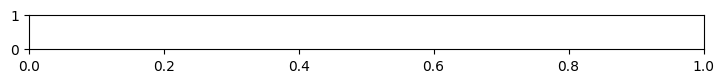

In [ ]:
plot_hypnograms(ppath, recordings, tbin=0, unit='h', ma_thr=20, title='')

In [ ]:
final_segments.shape

In [ ]:
val_correct

In [ ]:
y_true = final_test_real_labels
y_pred = final_test_predicted_labels

cf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 2, 3])
xticks = ['REM', 'Wake', 'NREM']
yticks = ['REM', 'Wake', 'NREM']

fig, ax = plt.subplots(figsize=(5, 5))
# fig = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
#             fmt='.2%', cmap='Blues', cbar=False, xticklabels=xticks, yticklabels=yticks)
fig = sns.heatmap(cf_matrix, annot=True,
                  cmap='Reds', cbar=False, xticklabels=xticks, yticklabels=yticks)

#fig.set(xlabel ="Predicted", ylabel = "Actual", title ='Confusion Matrix')

ax.set_xlabel('Predicted', fontsize=18)
ax.set_ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix', fontsize=22)


In [ ]:
# scaled_labels = [4] * idx + final_test_predicted_labels + [4] * (idx + 2) # Used for visualization on sleep annotation
# K = [0] * len(scaled_labels)
# s = ["%d\t%d\n" % (i,j) for (i,j) in zip(scaled_labels,K)]

# direct = ppath + '/' + name + '/remidx_lstm_' + name + '.txt'
# f = open(direct, 'w')
# f.writelines(s)
# f.close()

# print("Annotations saved.")